In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

In [3]:
# 2–3 层 MLP（MNIST：784 -> hidden -> [hidden] -> 10）
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, num_layers: int = 3):
        super().__init__()
        assert num_layers in (2, 3)
        if num_layers == 2:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes),
            )
        else:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, num_classes),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, n = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        n += X.size(0)
    return total_loss / n, correct / n


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, n = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        total_loss += loss.item() * X.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        n += X.size(0)
    return total_loss / n, correct / n

In [ ]:
import requests

requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

## 过拟合小数据实验：512 样本，目标 train acc ≥ 99%

In [ ]:
torch.manual_seed(42)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_full = MNIST(root="./data", train=True, download=True, transform=transform)
subset = Subset(mnist_full, torch.randperm(len(mnist_full))[:512].tolist())
loader_small = DataLoader(subset, batch_size=64, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_small = MLP(784, 256, 10, num_layers=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_small = torch.optim.Adam(model_small.parameters(), lr=1e-3)

history_small = {"train_loss": [], "train_acc": []}
target_acc = 0.99
epoch = 0
while True:
    loss, acc = train_epoch(model_small, loader_small, criterion, optimizer_small, device)
    history_small["train_loss"].append(loss)
    history_small["train_acc"].append(acc)
    epoch += 1
    if epoch % 20 == 0 or acc >= target_acc:
        print(f"Epoch {epoch}: train loss={loss:.4f}, train acc={acc:.4f}")
    if acc >= target_acc:
        print(f"train acc >= 99% (actual {acc:.4f}) in {epoch} epochs")
        break

100%|██████████| 9.91M/9.91M [00:00<00:00, 32.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.91MB/s]


Epoch 8: train loss=0.0600, train acc=0.9922
train acc >= 99% (actual 0.9922) in 8 epochs


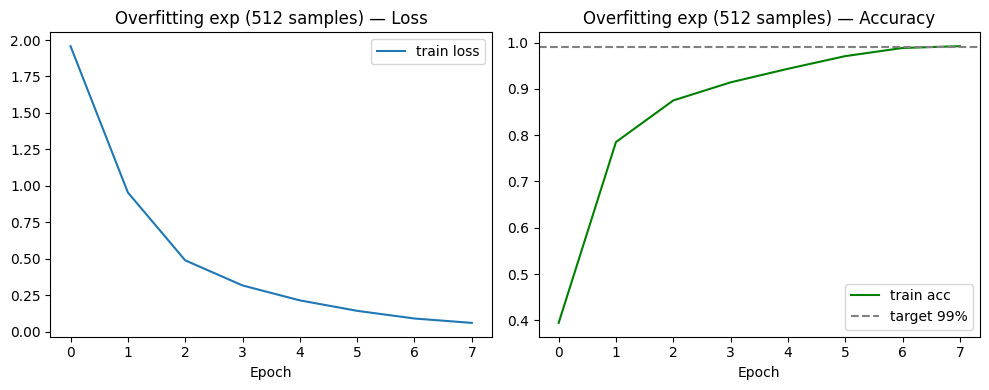

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history_small["train_loss"], label="train loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Overfitting exp (512 samples) — Loss")
ax2.plot(history_small["train_acc"], label="train acc", color="green")
ax2.axhline(y=0.99, color="gray", linestyle="--", label="target 99%")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Overfitting exp (512 samples) — Accuracy")
plt.tight_layout()
plt.show()

## 正常训练：完整 MNIST

In [11]:
# 完整 MNIST
train_set = MNIST(root="./data", train=True, download=True, transform=transform)
test_set = MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

model_full = MLP(784, 256, 10, num_layers=3).to(device)
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=1e-3)

history_full = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
n_epochs = 15
for ep in range(1, n_epochs + 1):
    tl, ta = train_epoch(model_full, train_loader, criterion, optimizer_full, device)
    vl, va = evaluate(model_full, test_loader, criterion, device)
    history_full["train_loss"].append(tl)
    history_full["train_acc"].append(ta)
    history_full["test_loss"].append(vl)
    history_full["test_acc"].append(va)
    print(f"Epoch {ep}/{n_epochs}:")
    print(f"- train loss={tl} acc={ta}")
    print(f"- test loss={vl} acc={va}")
    print("=" * 60)

print(f"\nfinal test accuracy: {history_full['test_acc'][-1]}")

Epoch 1/15:
- train loss=0.25754183750152587 acc=0.9248833333333333
- test loss=0.10867992108017206 acc=0.9653
Epoch 2/15:
- train loss=0.09788157498836517 acc=0.9696
- test loss=0.08755155486911535 acc=0.9729
Epoch 3/15:
- train loss=0.06651438372433185 acc=0.97895
- test loss=0.07737669540494681 acc=0.9752
Epoch 4/15:
- train loss=0.04821620147724946 acc=0.9845833333333334
- test loss=0.08540381682515144 acc=0.973
Epoch 5/15:
- train loss=0.03872553190340598 acc=0.9873333333333333
- test loss=0.08484564455568325 acc=0.9748
Epoch 6/15:
- train loss=0.02929827185086906 acc=0.9899333333333333
- test loss=0.07776385779781267 acc=0.976
Epoch 7/15:
- train loss=0.02522512362735967 acc=0.9915333333333334
- test loss=0.07805021865726448 acc=0.9799
Epoch 8/15:
- train loss=0.023931747719024617 acc=0.9923
- test loss=0.08812766580032184 acc=0.9771
Epoch 9/15:
- train loss=0.020972620130392413 acc=0.99305
- test loss=0.08104219655883499 acc=0.9798
Epoch 10/15:
- train loss=0.01613843192824473 a

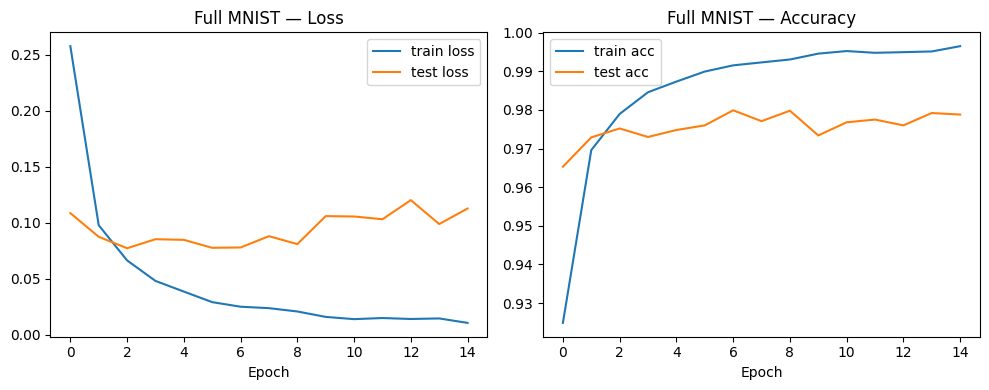

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history_full["train_loss"], label="train loss")
ax1.plot(history_full["test_loss"], label="test loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Full MNIST — Loss")
ax2.plot(history_full["train_acc"], label="train acc")
ax2.plot(history_full["test_acc"], label="test acc")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Full MNIST — Accuracy")
plt.tight_layout()
plt.show()